# OpenAltimetry get ATL03

Get ATL03 data using [OpenAltimetry](https://openaltimetry.org/data/icesat2/).
Browse OpenAltimetry to an area you are interested in seelct 'ATL07' in the box on the right -> 'Select a region' -> 'View elevation profile' -> 'Get API URL'

URL and beam you are interested in:

In [92]:
url = 'http://openaltimetry.org/data/api/icesat2/atl07?date=2019-09-18&minx=-57.59762573242188&miny=-65.3666687011719&maxx=-56.92471313476563&maxy=-64.6525573730469&trackId=1260&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
#url = 'http://openaltimetry.org/data/api/icesat2/atl07?date=2019-09-18&minx=-58.01785278320313&miny=-65.74844360351565&maxx=-56.93020629882813&maxy=-64.67178344726565&trackId=1260&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
#url = 'http://openaltimetry.org/data/api/icesat2/atl07?date=2021-12-22&minx=-133.89175415039077&miny=72.26669311523435&maxx=-133.4152221679689&maxy=72.57293701171872&trackId=1386&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
gtx = 'gt2l'

In [74]:
%matplotlib widget
import os
import ee
import geemap
import requests
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import glob                          # Package to locate files on disk
import h5py                          # general HDF5 reading/writing library
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms

Script uses an edited version of the code Philipp Arndt supplied in the Data Visualization tutorial. It is available in utils/oa.py

In [75]:
from utils.oa import dataCollector

In [76]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data'):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData(verbose=True)
    myplot = mydata.plotData(title=title)
    return (myplot, mydata)

In [77]:
#myplot, mydata = plot_from_oa_url(url=url, gtx=gtx, title='Some sea ice')
#myplot.savefig('photonfigure.jpg', dpi=300)
#myplot

In [93]:
mydata = dataCollector(oaurl=url,beam=gtx)
mydata.requestData(verbose=True)
#vars(mydata)

---> requesting ATL03 data... Done.
---> requesting ATL07 data... Done.
---> requesting ATL12 data... Done.


In [36]:
#fig = plt.figure()
#plt.scatter(mydata.atl03.lat,mydata.atl03.h,s=2, color='black', alpha=0.2,label='ATL03')
#plt.xlabel('lat')
#plt.ylabel('h')
#plt.legend(loc='lower right')

Methods from [Braakmann-Folgmann et al. (2022)](https://doi.org/10.1016/j.rse.2021.112855):

"For ICESat-2 we use Level 2A, ATL03 photon data as a primary product, because iceberg heights are filtered out in the higher level products. For each track, we analyze the three strong beams separately and discard the weak beams. Low confidence flagged photons (2 and below) are filtered out and 150 photons each are averaged along-track, to reduce noise. We then extract the mean sea surface height, ocean tides and inverted barometer effect from Level 3A version 3 ATL07 data, interpolated to the ATL03 locations. These are subtracted from the photon heights, yielding sea surface heights that agree with the ATL07 sea surface heights, and to derive iceberg freeboard. Finally, we discard freeboard measurements from both altimeters below 20 and above 100 m and measurements outside the iceberg polygon derived from the near-coincident satellite imagery."

In [100]:
#Drop low confidence observations
atl03 = mydata.atl03
atl03 = atl03.loc[(atl03['conf'] == 'High')|(atl03['conf']=='Medium')|(atl03['conf']=='Low')].reset_index(drop=True)

In [101]:
#150 photons each averaged along-track
atl03_150 = atl03.groupby(np.arange(len(atl03))//150).mean()

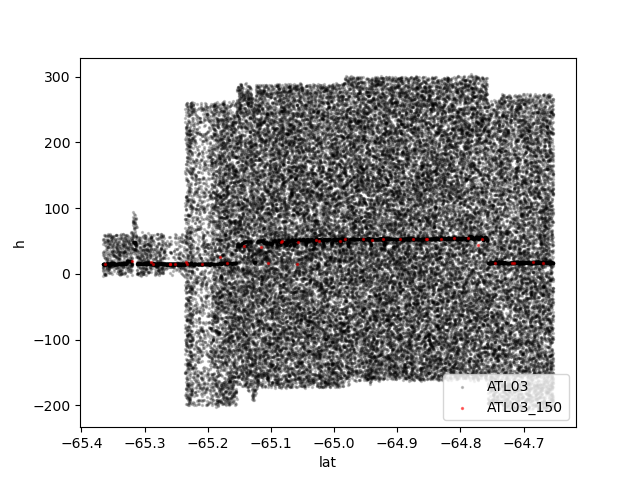

In [102]:
fig = plt.figure()
plt.scatter(mydata.atl03.lat,mydata.atl03.h,s=2, color='black', alpha=0.2,label='ATL03')
plt.scatter(atl03_150.lat,atl03_150.h,s=2, color='red', alpha=0.5,label='ATL03_150')
plt.xlabel('lat')
plt.ylabel('h')
plt.legend(loc='lower right')

The ATL07 data that I got from OpenAltimetry doesn't have the values for the applied geophysical corrections in it (which we need to correct the ATL03!). On OpenAltimetry you can press 'Download subsetted HDF5 (via NSIDC)'. Download this file and use that in these next steps:

In [108]:
# Prepare coordinate transformations between lat/lon and the ATL10 coordinate system
crs=CRS.from_epsg(3413)
to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

# use the glob package to find the ATL07s that we downloaded
file = 'ATL07/processed_ATL07-02_20190918135008_12600401_005_01.h5'
#file = 'ATL07/processed_ATL07-01_20211222044914_13861301_005_01.h5'
with h5py.File(file,'r') as h5f:
    try:
        lat=np.array(h5f['gt2l']['sea_ice_segments']['latitude'])
        lon=np.array(h5f['gt2l']['sea_ice_segments']['longitude'])
    except Exception:
        pass
    x,y = to_xy_crs.transform(lat, lon)
    file_xyth={'x':x,'y':y,'lat':lat,'lon':lon, 
               'ocean_tides':np.array(h5f['gt2l']['sea_ice_segments']['geophysical']['height_segment_ocean']),
               'inverted_barom':np.array(h5f['gt2l']['sea_ice_segments']['geophysical']['height_segment_ib']),
               'mss':np.array(h5f['gt2l']['sea_ice_segments']['geophysical']['height_segment_mss']),
               't':np.array(h5f['gt2l']['sea_ice_segments']['delta_time'])}
    atl07 = pd.DataFrame(data=file_xyth)


In [109]:
atl07

,x,y,lat,lon,ocean_tides,inverted_barom,mss,t
0,-1.141951e+07,-5.329048e+07,-64.652604,-57.094878,-0.725705,0.295421,17.365681,5.405365e+07
1,-1.141961e+07,-5.329078e+07,-64.652747,-57.094917,-0.725714,0.295424,17.365122,5.405365e+07
2,-1.141974e+07,-5.329118e+07,-64.652934,-57.094968,-0.725727,0.295428,17.364368,5.405365e+07
3,-1.141987e+07,-5.329155e+07,-64.653112,-57.095017,-0.725738,0.295431,17.363703,5.405365e+07
4,-1.141993e+07,-5.329172e+07,-64.653189,-57.095038,-0.725743,0.295434,17.363440,5.405365e+07
...,...,...,...,...,...,...,...,...
4230,-1.193929e+07,-5.484451e+07,-65.366206,-57.281306,-0.793717,0.300692,15.007689,5.405366e+07
4231,-1.193938e+07,-5.484475e+07,-65.366313,-57.281335,-0.793730,0.300690,15.007431,5.405366e+07
4232,-1.193943e+07,-5.484491e+07,-65.366383,-57.281354,-0.793740,0.300690,15.007236,5.405366e+07
4233,-1.193951e+07,-5.484514e+07,-65.366488,-57.281382,-0.793753,0.300688,15.006968,5.405366e+07


We need to correct for mean sea surface, the inverted barometer effect and ocean tides.

In [110]:
atl03_150['corr_h'] = atl03_150['h']-np.mean(atl07.mss)-np.mean(atl07.inverted_barom)-np.mean(atl07.ocean_tides)

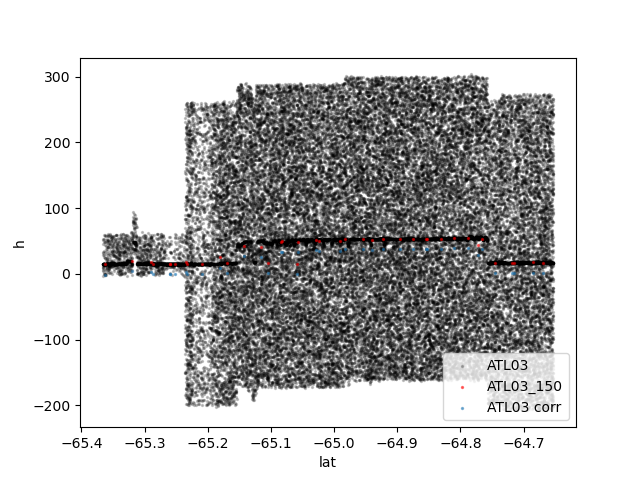

In [111]:
fig = plt.figure()
plt.scatter(mydata.atl03.lat,mydata.atl03.h,s=2, color='black', alpha=0.2,label='ATL03')
plt.scatter(atl03_150.lat,atl03_150.h,s=2, color='red', alpha=0.5,label='ATL03_150')
plt.scatter(atl03_150.lat,atl03_150.corr_h,s=2, alpha=0.5,label='ATL03 corr')
plt.xlabel('lat')
plt.ylabel('h')
plt.legend(loc='lower right')

The blue line is the corrected ATL03 value, which should give the sea ice elevation according to Braakmann-Folgmann...

Text(0.5, 1.0, 'Freeboard height')

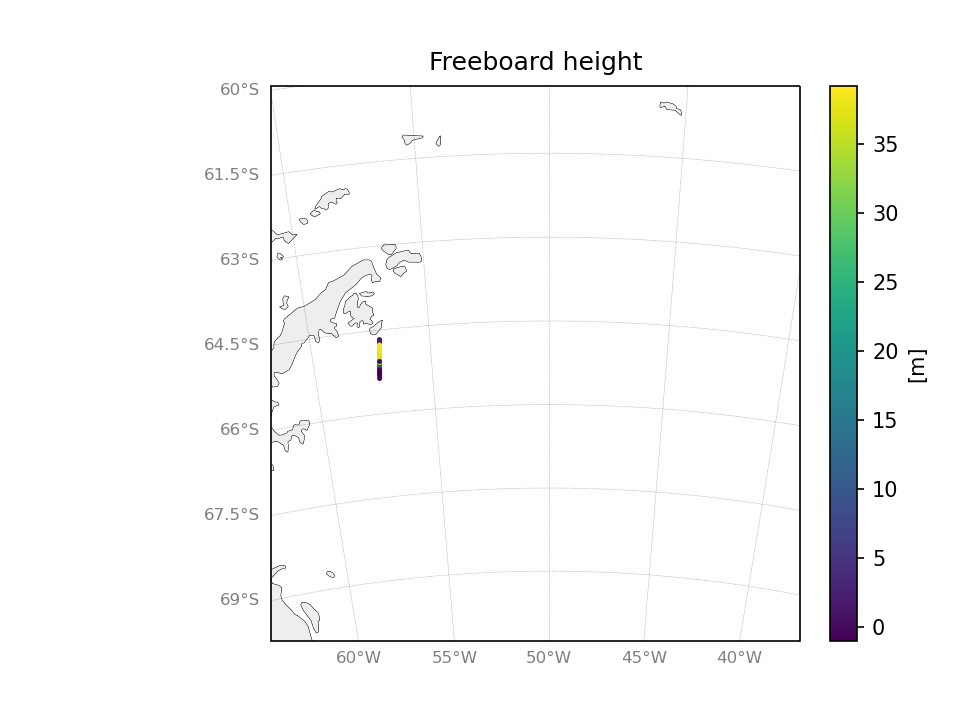

In [113]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

fig=plt.figure(dpi=150)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=-50, central_latitude=-60, globe=None))
ax.coastlines(resolution='50m',linewidth=0.5)
ax.set_extent([-60,-41,-70,-60],crs=ccrs.PlateCarree())
im = plt.scatter(atl03_150.lon,atl03_150.lat,c=atl03_150.corr_h,s=2,transform=ccrs.PlateCarree())
ax.add_feature(land_50m, facecolor='#eeeeee')
cbar = fig.colorbar(im, ax=ax, label='[m]',fraction=0.046, pad=0.04)

gl = ax.gridlines(linewidth=0.3, draw_labels=True, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}

plt.title(f'Freeboard height')

